<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/ArsenicAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Colab setup ===
# If in Colab, run this to mount Drive
from google.colab import drive  # safe if not in Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:


# Optional. Colab already has torch. Keep this if you want a fixed version.
# !pip -q install torch torchvision torchaudio

import os, math, time, random, pickle, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Reproducibility and dtype
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
ROOT = "/content/drive/MyDrive/ArsenicSTS"
DATA_CSV = f"{ROOT}/UVVisData/0.30MB_AuNP_As.csv"
CKPT_ROOT = f"{ROOT}/aae_ckpts"
FIG_ROOT = f"{ROOT}/figs"
GEN_ROOT = f"{ROOT}/generated"
os.makedirs(CKPT_ROOT, exist_ok=True)
os.makedirs(FIG_ROOT, exist_ok=True)
os.makedirs(GEN_ROOT, exist_ok=True)

# ===== Data loader and preprocessing =====
def load_uvvis_csv(path, baseline_correct=True):
    """Returns wavelengths [601], conc_list [6], A_mat [601,6] after optional baseline removal at 800 nm."""
    df = pd.read_csv(path)
    # normalize column names to str
    df.columns = [str(c).strip() for c in df.columns]
    assert "Wavelength" in df.columns, "CSV must have 'Wavelength' column"
    wl = df["Wavelength"].to_numpy().astype(np.float32)
    # extract concentration columns that are numeric when cast to float
    conc_cols = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            float(c)
            conc_cols.append(c)
        except Exception:
            pass
    # sort by numeric concentration ascending
    conc_vals = np.array(sorted([float(c) for c in conc_cols], key=float), dtype=np.float32)
    conc_cols_sorted = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    # Build matrix in that order
    A = np.stack([df[c].to_numpy().astype(np.float32) for c in conc_cols_sorted], axis=1)  # [601,6]
    # Optional baseline correction using A at 800 nm
    if baseline_correct:
        # find index of 800 nm
        idx_800 = int(np.argmin(np.abs(wl - 800.0)))
        base = A[idx_800:idx_800+1, :]  # [1,6]
        A = A - base
    return wl, conc_vals, A

def split_loco(concs):
    """Yield folds with one held concentration each."""
    for c_hold in concs:
        train = [c for c in concs if c != c_hold]
        yield c_hold, np.array(train, dtype=np.float32)

class SpectraScaler:
    """Featurewise standardization using training stats only. Works on [N,601] row vectors."""
    def __init__(self):
        self.mean = None
        self.std = None
    def fit(self, X):  # X [N,601]
        self.mean = X.mean(axis=0, keepdims=True)
        self.std  = X.std(axis=0, keepdims=True) + 1e-6
    def transform(self, X):
        return (X - self.mean) / self.std
    def inverse(self, Xz):
        return Xz * self.std + self.mean
    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump({"mean": self.mean, "std": self.std}, f)
    @staticmethod
    def load(path):
        with open(path, "rb") as f:
            d = pickle.load(f)
        sc = SpectraScaler()
        sc.mean, sc.std = d["mean"], d["std"]
        return sc

# Load data
wl, concs_all, A = load_uvvis_csv(DATA_CSV, baseline_correct=True)  # A [601,6]
assert A.shape[0] == 601, "Expected 601 wavelengths"
assert A.shape[1] == len(concs_all), "Mismatch in concentration columns"
print("Wavelengths:", wl.shape, "Concentrations:", concs_all, "A:", A.shape)

# Build per-spectrum dataset
# Each column is a sample x in R^601 and scalar c in µg/L
SPECTRA = {float(c): A[:, i].astype(np.float32) for i, c in enumerate(concs_all)}
WL_MIN, WL_MAX = wl.min(), wl.max()
C_MIN, C_MAX = float(concs_all.min()), float(concs_all.max())

def scale_c(c, cmin=C_MIN, cmax=C_MAX):
    return (c - cmin) / (cmax - cmin + 1e-12)

def unscale_c(cs, cmin=C_MIN, cmax=C_MAX):
    return cs * (cmax - cmin) + cmin


Wavelengths: (601,) Concentrations: [ 0. 10. 20. 30. 40. 60.] A: (601, 6)


In [6]:
# ===== Small MLP building block =====
class MLP(nn.Module):
    def __init__(self, in_dim, hidden, out_dim, n_layers=3, act=nn.SiLU, layernorm=True, final_act=None):
        super().__init__()
        dims = [in_dim] + [hidden]*n_layers + [out_dim]
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i], dims[i+1])]
            if layernorm:
                layers += [nn.LayerNorm(dims[i+1])]
            layers += [act()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        if final_act is not None:
            layers += [final_act()]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# ===== AAE components =====
class Encoder(nn.Module):
    def __init__(self, in_dim=601, hidden=256, latent_dim=4, n_layers=3):
        super().__init__()
        self.f = MLP(in_dim, hidden, latent_dim, n_layers=n_layers, act=nn.SiLU, layernorm=True)
    def forward(self, x):
        return self.f(x)

class CEmbed(nn.Module):
    def __init__(self, emb_dim=8):
        super().__init__()
        self.f = MLP(1, hidden=16, out_dim=emb_dim, n_layers=1, act=nn.SiLU, layernorm=False)
    def forward(self, c01):
        return self.f(c01)

class Decoder(nn.Module):
    def __init__(self, latent_dim=4, c_emb_dim=8, hidden=256, out_dim=601, n_layers=3):
        super().__init__()
        self.f = MLP(latent_dim + c_emb_dim, hidden, out_dim, n_layers=n_layers, act=nn.SiLU, layernorm=True)
    def forward(self, z, cemb):
        h = torch.cat([z, cemb], dim=-1)
        return self.f(h)

class Discriminator(nn.Module):
    def __init__(self, latent_dim=4, hidden=128):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(latent_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, z):
        return self.f(z)  # logits

class AuxRegressor(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.SiLU(),
            nn.Linear(32, 1)
        )
    def forward(self, z):
        return self.f(z)  # predicts c_scaled


In [7]:
# ===== Utilities =====
def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

def pearsonr(a, b):
    a = a - a.mean(); b = b - b.mean()
    return float((a*b).sum() / (np.sqrt((a*a).sum()) * np.sqrt((b*b).sum()) + 1e-12))

def peak_nm(wl, spec):
    return float(wl[int(np.argmax(spec))])

def linear_baseline_interp(concs_known, A_known, c_target):
    """Interpolate at each wavelength separately using two nearest neighbors in conc space.
       A_known shape [601, K] for K known concs in ascending concs_known."""
    concs = np.array(concs_known, dtype=np.float32)
    A_kn = np.array(A_known, dtype=np.float32)  # [601,K]
    # find left and right neighbors for c_target
    if c_target <= concs.min():
        # extrapolate using first two
        i0, i1 = 0, 1
    elif c_target >= concs.max():
        i0, i1 = len(concs)-2, len(concs)-1
    else:
        i1 = int(np.searchsorted(concs, c_target, side="right"))
        i0 = i1 - 1
    c0, c1 = concs[i0], concs[i1]
    w = (c_target - c0) / (c1 - c0 + 1e-12)
    return (1 - w) * A_kn[:, i0] + w * A_kn[:, i1]

def make_batch(X, C, batch_size):
    n = X.shape[0]
    idx = np.random.randint(0, n, size=(batch_size,))
    return torch.from_numpy(X[idx]).float().to(DEVICE), torch.from_numpy(C[idx]).float().to(DEVICE)

def save_fold_artifacts(fold_dir, enc, dec, disc, aux, scaler, meta):
    os.makedirs(fold_dir, exist_ok=True)
    torch.save(enc.state_dict(),  os.path.join(fold_dir, "encoder.pt"))
    torch.save(dec.state_dict(),  os.path.join(fold_dir, "decoder.pt"))
    torch.save(disc.state_dict(), os.path.join(fold_dir, "disc.pt"))
    torch.save(aux.state_dict(),  os.path.join(fold_dir, "aux.pt"))
    scaler.save(os.path.join(fold_dir, "scaler.pkl"))
    with open(os.path.join(fold_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

def load_fold(fold_dir, latent_dim=4, c_emb_dim=8):
    enc = Encoder(latent_dim=latent_dim).to(DEVICE)
    dec = Decoder(latent_dim=latent_dim, c_emb_dim=c_emb_dim).to(DEVICE)
    disc = Discriminator(latent_dim=latent_dim).to(DEVICE)
    aux = AuxRegressor(latent_dim=latent_dim).to(DEVICE)
    enc.load_state_dict(torch.load(os.path.join(fold_dir, "encoder.pt"), map_location=DEVICE))
    dec.load_state_dict(torch.load(os.path.join(fold_dir, "decoder.pt"), map_location=DEVICE))
    disc.load_state_dict(torch.load(os.path.join(fold_dir, "disc.pt"), map_location=DEVICE))
    aux.load_state_dict(torch.load(os.path.join(fold_dir, "aux.pt"), map_location=DEVICE))
    scaler = SpectraScaler.load(os.path.join(fold_dir, "scaler.pkl"))
    with open(os.path.join(fold_dir, "meta.json"), "r") as f:
        meta = json.load(f)
    cembed = CEmbed(emb_dim=meta["c_emb_dim"]).to(DEVICE)
    cembed.load_state_dict(torch.load(os.path.join(fold_dir, "cembed.pt"), map_location=DEVICE))
    return enc.eval(), dec.eval(), disc.eval(), aux.eval(), cembed.eval(), scaler, meta


In [8]:
# ===== Core trainer for one LOCO fold =====
def train_fold(fold_spec,
               latent_dim=4, c_emb_dim=8, batch_size=32,
               max_steps=6000, patience=500,
               w_rec=0.9, w_adv=0.1, w_aux=0.05,
               lr=4e-4, lr_min=1e-5):

    c_hold = float(fold_spec["c_hold"])
    train_concs = np.array(fold_spec["train_concs"], dtype=np.float32)
    fold_dir = os.path.join(CKPT_ROOT, f"fold_{int(c_hold)}")
    os.makedirs(fold_dir, exist_ok=True)

    # Build training arrays
    X_train = np.stack([SPECTRA[c] for c in train_concs], axis=0)  # [5,601]
    C_train = np.array([scale_c(c) for c in train_concs], dtype=np.float32).reshape(-1,1)

    scaler = SpectraScaler(); scaler.fit(X_train)  # featurewise
    Xz = scaler.transform(X_train).astype(np.float32)

    # Tiny dataset. We will repeatedly sample minibatches from it.
    # Validation proxy will be EMA of training recon loss.
    # Models
    enc = Encoder(latent_dim=latent_dim).to(DEVICE)
    cembed = CEmbed(emb_dim=c_emb_dim).to(DEVICE)
    dec = Decoder(latent_dim=latent_dim, c_emb_dim=c_emb_dim).to(DEVICE)
    disc = Discriminator(latent_dim=latent_dim).to(DEVICE)
    aux = AuxRegressor(latent_dim=latent_dim).to(DEVICE)

    # Opts and sched
    opt_g = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()) +
                             list(cembed.parameters()) + list(aux.parameters()), lr=lr)
    T_max = max_steps
    sch_g = torch.optim.lr_scheduler.CosineAnnealingLR(opt_g, T_max=T_max, eta_min=lr_min)

    opt_d = torch.optim.Adam(disc.parameters(), lr=lr*0.5)

    bce = nn.BCEWithLogitsLoss()
    mse = nn.MSELoss()

    best_rec = float("inf")
    best_step = 0
    ema_rec = None
    hist = {"step": [], "rec": [], "adv": [], "aux": []}

    Xnp = Xz.astype(np.float32); Cnp = C_train.astype(np.float32)

    for step in range(1, max_steps+1):
        # Make a batch by resampling from the 5 rows
        xb, cb = make_batch(Xnp, Cnp, batch_size)
        z = enc(xb)  # [B,L]
        cemb = cembed(cb)  # [B,E]
        x_rec = dec(z, cemb)

        # --- Discriminator update ---
        # Prior samples as "real"
        z_real = torch.randn_like(z)
        logits_real = disc(z_real)
        logits_fake = disc(z.detach())
        d_loss = bce(logits_real, torch.ones_like(logits_real)) + \
                 bce(logits_fake, torch.zeros_like(logits_fake))
        opt_d.zero_grad(set_to_none=True)
        d_loss.backward()
        opt_d.step()

        # --- Generator (E+D+H) update ---
        rec = mse(x_rec, xb)
        # fool the discriminator
        logits_fake2 = disc(z)
        adv = bce(logits_fake2, torch.ones_like(logits_fake2))
        # auxiliary
        c_pred = aux(z)
        aux_loss = mse(c_pred, cb)
        loss = w_rec*rec + w_adv*adv + w_aux*aux_loss

        opt_g.zero_grad(set_to_none=True)
        loss.backward()
        opt_g.step()
        sch_g.step()

        # Track
        rec_val = float(rec.detach().cpu())
        ema_rec = rec_val if ema_rec is None else 0.98*ema_rec + 0.02*rec_val
        hist["step"].append(step); hist["rec"].append(rec_val)
        hist["adv"].append(float(adv.detach().cpu()))
        hist["aux"].append(float(aux_loss.detach().cpu()))

        # Early stopping on best raw rec
        if rec_val < best_rec - 1e-6:
            best_rec = rec_val
            best_step = step
            # Save best so far
            torch.save(enc.state_dict(),  os.path.join(fold_dir, "encoder.pt"))
            torch.save(dec.state_dict(),  os.path.join(fold_dir, "decoder.pt"))
            torch.save(disc.state_dict(), os.path.join(fold_dir, "disc.pt"))
            torch.save(aux.state_dict(),  os.path.join(fold_dir, "aux.pt"))
            torch.save(cembed.state_dict(), os.path.join(fold_dir, "cembed.pt"))
            scaler.save(os.path.join(fold_dir, "scaler.pkl"))
            with open(os.path.join(fold_dir, "train_hist.json"), "w") as f:
                json.dump(hist, f)
        if step - best_step >= patience:
            print(f"[fold {int(c_hold)}] Early stop at {step}. Best step {best_step} rec {best_rec:.4e}")
            break

    # Meta
    meta = {
        "c_hold": float(c_hold),
        "train_concs": [float(x) for x in train_concs.tolist()],
        "latent_dim": int(latent_dim),
        "c_emb_dim": int(c_emb_dim),
        "best_step": int(best_step),
        "best_rec": float(best_rec),
        "w_rec": float(w_rec), "w_adv": float(w_adv), "w_aux": float(w_aux),
        "lr": float(lr), "lr_min": float(lr_min),
        "max_steps": int(max_steps), "patience": int(patience)
    }
    with open(os.path.join(fold_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    # Return quick info
    return {"fold_dir": fold_dir, "meta": meta, "best_rec": best_rec}


In [9]:
# ===== Generation helpers =====
def decode_many(dec, cembed, scaler, c_target, N, latent_dim, c_emb_dim):
    with torch.no_grad():
        z = torch.randn(N, latent_dim, device=DEVICE)
        c01 = torch.full((N,1), fill_value=scale_c(c_target), device=DEVICE)
        cemb = cembed(c01)
        xz = dec(z, cemb)  # standardized
        x = scaler.inverse(xz.detach().cpu().numpy())
    return x  # [N,601]

def filtered_reject(dec, cembed, aux, scaler, c_target, N, latent_dim, eps=0.02, max_trials=20000):
    out = []
    trials = 0
    ct = torch.tensor([[scale_c(c_target)]], device=DEVICE)
    while len(out) < N and trials < max_trials:
        trials += 256
        z = torch.randn(256, latent_dim, device=DEVICE)
        c_pred = aux(z)
        mask = (c_pred - ct).abs() <= eps
        if mask.any():
            z_keep = z[mask.squeeze(1)]
            with torch.no_grad():
                cemb = cembed(ct.repeat(z_keep.size(0),1))
                xz = dec(z_keep, cemb)
            x = scaler.inverse(xz.detach().cpu().numpy())
            out.append(x)
    if len(out) == 0:
        return np.zeros((0, 601), dtype=np.float32)
    X = np.concatenate(out, axis=0)
    return X[:N]

def filtered_opt(dec, cembed, aux, scaler, c_target, N, latent_dim, steps=200, lr=0.05, lam=0.01, sigma=0.05):
    # gradient-based targeting toward c*
    X = []
    ct = torch.tensor([[scale_c(c_target)]], device=DEVICE)
    for _ in range(N):
        z = torch.randn(1, latent_dim, device=DEVICE, requires_grad=True)
        opt = torch.optim.Adam([z], lr=lr)
        for _ in range(steps):
            cp = aux(z)
            loss = (cp - ct).pow(2).mean() + lam*(z.pow(2).mean())
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
        # small local noise
        z_final = z.detach() + sigma*torch.randn_like(z)
        with torch.no_grad():
            cemb = cembed(ct)
            xz = dec(z_final, cemb)
        X.append(scaler.inverse(xz.detach().cpu().numpy()))
    return np.concatenate(X, axis=0)

# ===== Public API =====
_LAST_FOLD_CACHE = {}  # c_hold -> loaded modules

def _pick_fold_for_c(c_target):
    # Choose fold that held the nearest concentration to c_target
    diffs = {float(c): abs(c_target - float(c)) for c in concs_all}
    nearest = min(diffs, key=diffs.get)
    return int(nearest)

def _load_fold_cached(c_hold):
    if c_hold in _LAST_FOLD_CACHE:
        return _LAST_FOLD_CACHE[c_hold]
    fold_dir = os.path.join(CKPT_ROOT, f"fold_{int(c_hold)}")
    enc, dec, disc, aux, cemb, scaler, meta = load_fold(fold_dir)
    _LAST_FOLD_CACHE[c_hold] = (enc, dec, disc, aux, cemb, scaler, meta)
    return _LAST_FOLD_CACHE[c_hold]

def generate_spectra(c_target, N=64, mode="conditional"):
    """Returns np.ndarray [N,601] in baseline-corrected absorbance space."""
    fold_to_use = _pick_fold_for_c(c_target)
    enc, dec, disc, aux, cemb, scaler, meta = _load_fold_cached(fold_to_use)
    latent_dim = meta["latent_dim"]; c_emb_dim = meta["c_emb_dim"]

    if mode == "conditional":
        X = decode_many(dec, cemb, scaler, c_target, N, latent_dim, c_emb_dim)
    elif mode == "filtered_reject":
        X = filtered_reject(dec, cemb, aux, scaler, c_target, N, latent_dim, eps=0.02)
    elif mode == "filtered_opt":
        X = filtered_opt(dec, cemb, aux, scaler, c_target, N, latent_dim, steps=200, lr=0.05, lam=0.01, sigma=0.05)
    else:
        raise ValueError("mode must be one of {'conditional','filtered_reject','filtered_opt'}")
    # Save optional dump
    np.save(os.path.join(GEN_ROOT, f"gen_c_{int(round(c_target))}_{mode}.npy"), X.astype(np.float32))
    return X


In [10]:
def evaluate_loco(N=64, modes=("conditional","filtered_opt")):
    rows = []
    for c_hold, train_concs in split_loco(concs_all):
        # train this fold if not already present
        fold_dir = os.path.join(CKPT_ROOT, f"fold_{int(c_hold)}")
        if not os.path.exists(os.path.join(fold_dir, "encoder.pt")):
            print(f"Training fold for held {int(c_hold)}")
            train_fold({"c_hold": float(c_hold), "train_concs": train_concs})
        # load trained
        enc, dec, disc, aux, cemb, scaler, meta = load_fold(fold_dir)
        latent_dim = meta["latent_dim"]; c_emb_dim = meta["c_emb_dim"]

        # Real held spectrum in baseline-corrected space with same scaler
        x_true = SPECTRA[float(c_hold)]
        # for baseline comparison we build linear interpolation from training concs and spectra
        A_train_mat = np.stack([SPECTRA[float(c)] for c in train_concs], axis=1)
        lin_pred = linear_baseline_interp(train_concs, A_train_mat, float(c_hold))

        # For metrics, we compare mean generated spectrum to real held
        for mode in modes:
            if mode == "conditional":
                X = decode_many(dec, cemb, scaler, float(c_hold), N, latent_dim, c_emb_dim)
            elif mode == "filtered_opt":
                X = filtered_opt(dec, cemb, aux, scaler, float(c_hold), N, latent_dim, steps=200, lr=0.05, lam=0.01, sigma=0.05)
            elif mode == "filtered_reject":
                X = filtered_reject(dec, cemb, aux, scaler, float(c_hold), N, latent_dim, eps=0.02)
            else:
                continue
            x_mean = X.mean(axis=0)

            r = pearsonr(x_true, x_mean)
            e = rmse(x_true, x_mean)
            p_err = abs(peak_nm(wl, x_true) - peak_nm(wl, x_mean))

            # linear baseline metrics
            e_lin = rmse(x_true, lin_pred)
            r_lin = pearsonr(x_true, lin_pred)

            rows.append({
                "c_hold": float(c_hold),
                "mode": mode,
                "rmse": e,
                "pearson_r": r,
                "peak_shift_nm": p_err,
                "rmse_linear": e_lin,
                "pearson_r_linear": r_lin
            })

            # Plot overlay and uncertainty band
            fig = plt.figure(figsize=(8,4))
            plt.plot(wl, x_true, label=f"Real c={int(c_hold)}")
            plt.plot(wl, x_mean, label=f"AAE mean {mode}")
            # uncertainty band
            std = X.std(axis=0)
            plt.fill_between(wl, x_mean-std, x_mean+std, alpha=0.2, label="AAE ±1 sd")
            # linear baseline
            plt.plot(wl, lin_pred, linestyle=":", label="Linear baseline")
            plt.xlabel("Wavelength (nm)"); plt.ylabel("Absorbance (baseline corrected)")
            plt.legend(loc="best")
            plt.tight_layout()
            outpng = os.path.join(FIG_ROOT, f"loco_c_{int(c_hold)}_{mode}.png")
            plt.savefig(outpng, dpi=160); plt.close(fig)

        # Save a CSV of generated mean spectra for this held concentration
        out_csv = os.path.join(GEN_ROOT, f"loco_c_{int(c_hold)}.csv")
        cols = {}
        for mode in modes:
            # regenerate to avoid storing large arrays
            if mode == "conditional":
                X = decode_many(dec, cemb, scaler, float(c_hold), N, latent_dim, c_emb_dim)
            else:
                X = filtered_opt(dec, cemb, aux, scaler, float(c_hold), N, latent_dim)
            cols[f"gen_mean_{mode}"] = X.mean(axis=0)
        df = pd.DataFrame({"Wavelength": wl, "Real": x_true, "Linear": lin_pred, **cols})
        df.to_csv(out_csv, index=False)

    dfres = pd.DataFrame(rows)
    dfres_path = os.path.join(ROOT, "loco_results.csv")
    dfres.to_csv(dfres_path, index=False)
    print("Saved LOCO results to", dfres_path)
    return dfres

def generate_grid(c_values, N_per=32, mode="conditional"):
    out = {}
    rows = []
    for c in c_values:
        X = generate_spectra(c, N=N_per, mode=mode)
        out[c] = X
        rows.append(np.concatenate([[c], X.mean(axis=0)], axis=0))
    grid = np.stack(rows, axis=0)
    cols = ["c"] + [f"{int(w)}" for w in wl]
    df = pd.DataFrame(grid, columns=cols)
    csv_path = os.path.join(GEN_ROOT, "gen_grid_interp.csv")
    df.to_csv(csv_path, index=False)
    return out


In [11]:
# ===== Train all folds and print LOCO table =====
metrics = evaluate_loco()   # trains missing folds, evaluates modes: conditional and filtered_opt
print(metrics)

# ===== Interpolate at c*=25 using conditional decoding =====
specs = generate_spectra(25.0, N=64, mode="conditional")
print("Generated specs shape:", specs.shape)

# ===== Same using filtered optimization =====
specs_opt = generate_spectra(25.0, N=64, mode="filtered_opt")
print("Generated specs_opt shape:", specs_opt.shape)

# ===== Smoothness diagnostic across midpoints =====
midpoints = [5, 15, 25, 35, 50]
grid = generate_grid(midpoints, N_per=32, mode="conditional")

# Simple smoothness score by total variation across concentrations
means = np.stack([grid[c].mean(axis=0) for c in midpoints], axis=0)  # [M,601]
tv = np.abs(np.diff(means, axis=0)).sum()  # scalar
print("Total variation across c midpoints:", float(tv))


Training fold for held 0
[fold 0] Early stop at 1983. Best step 1483 rec 2.2747e-05
Training fold for held 10
[fold 10] Early stop at 1395. Best step 895 rec 3.2301e-05
Training fold for held 20
[fold 20] Early stop at 1006. Best step 506 rec 1.7088e-05
Training fold for held 30
[fold 30] Early stop at 1117. Best step 617 rec 1.6933e-05
Training fold for held 40
[fold 40] Early stop at 1725. Best step 1225 rec 2.4530e-05
Training fold for held 60
[fold 60] Early stop at 1378. Best step 878 rec 6.8582e-05
Saved LOCO results to /content/drive/MyDrive/ArsenicSTS/loco_results.csv
    c_hold          mode      rmse  pearson_r  peak_shift_nm  rmse_linear  \
0      0.0   conditional  0.013299   0.955343            0.0     0.041023   
1      0.0  filtered_opt  0.027287   0.868159            0.0     0.041023   
2     10.0   conditional  0.013565   0.979066            0.0     0.020511   
3     10.0  filtered_opt  0.003823   0.991086            0.0     0.020511   
4     20.0   conditional  0.0285

#MLP

Training fold hold 10
[hold 10] step 200  rec 9.8360e-01  vl 1.0993e+00  ema 1.1081e+00
[hold 10] step 400  rec 1.0065e+00  vl 1.0974e+00  ema 1.0977e+00
[hold 10] step 600  rec 9.4386e-01  vl 1.0960e+00  ema 1.0960e+00
[hold 10] step 800  rec 9.7790e-01  vl 1.0942e+00  ema 1.0949e+00
[hold 10] step 1000  rec 1.0323e+00  vl 1.0925e+00  ema 1.0931e+00
[hold 10] early stop at 1004, best 4
Training fold hold 20
[hold 20] step 200  rec 9.3741e-01  vl 8.6643e-01  ema 8.7686e-01
[hold 20] step 400  rec 8.3752e-01  vl 8.6532e-01  ema 8.6594e-01
[hold 20] step 600  rec 9.9406e-01  vl 8.6530e-01  ema 8.6523e-01
[hold 20] step 800  rec 9.9973e-01  vl 8.6371e-01  ema 8.6401e-01
[hold 20] step 1000  rec 1.0118e+00  vl 8.6307e-01  ema 8.6323e-01
[hold 20] early stop at 1016, best 16
Training fold hold 30
[hold 30] step 200  rec 1.0450e+00  vl 9.4627e-01  ema 9.5027e-01
[hold 30] step 400  rec 9.5441e-01  vl 9.4672e-01  ema 9.4669e-01
[hold 30] step 600  rec 9.9826e-01  vl 9.4714e-01  ema 9.4631e-01

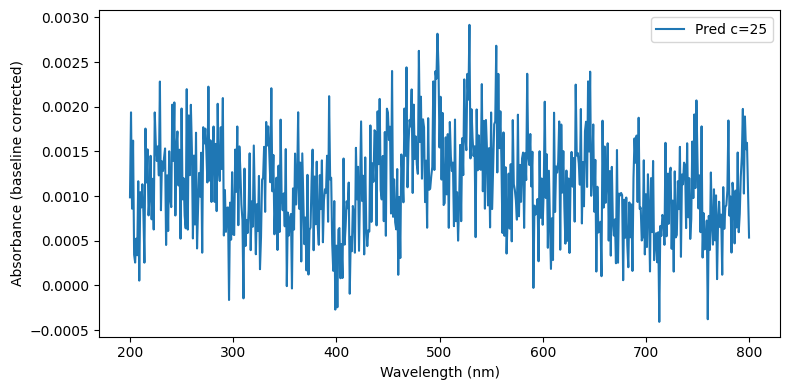

In [3]:
# === Setup ===
# If in Colab, mount Drive first:
# from google.colab import drive; drive.mount('/content/drive')

import os, math, json, time, random, pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
ROOT = "/content/drive/MyDrive/ArsenicSTS"
DATA_CSV = f"{ROOT}/UVVisData/0.30MB_AuNP_As.csv"
OUT_ROOT  = f"{ROOT}/coordnet_ckpts"
FIG_ROOT  = f"{ROOT}/figs_coordnet"
os.makedirs(OUT_ROOT, exist_ok=True)
os.makedirs(FIG_ROOT, exist_ok=True)

# === Data loading ===
def load_uvvis_csv(path, baseline_correct=True):
    df = pd.read_csv(path)
    df.columns = [str(c).strip() for c in df.columns]
    assert "Wavelength" in df.columns
    wl = df["Wavelength"].to_numpy().astype(np.float32)
    conc_cols = []
    for c in df.columns:
        if c == "Wavelength": continue
        try: float(c); conc_cols.append(c)
        except: pass
    conc_vals = np.array(sorted([float(c) for c in conc_cols], key=float), dtype=np.float32)
    cols_sorted = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([df[c].to_numpy().astype(np.float32) for c in cols_sorted], axis=1)  # [601,6]
    if baseline_correct:
        idx_800 = int(np.argmin(np.abs(wl - 800.0)))
        A = A - A[idx_800:idx_800+1, :]
    return wl, conc_vals, A  # [W], [K], [W,K]

wl, concs_all, A_mat = load_uvvis_csv(DATA_CSV, baseline_correct=True)
WMIN, WMAX = float(wl.min()), float(wl.max())
CMIN, CMAX = float(concs_all.min()), float(concs_all.max())

def scale01(x, lo, hi): return (x - lo) / (hi - lo + 1e-12)
def unscale01(y, lo, hi): return y*(hi-lo) + lo

# Pair grid
# Pairs (w, c) -> A
def make_pair_grid(wl, concs, A):
    W, K = A.shape
    ww = np.repeat(wl.reshape(W,1), K, axis=1)
    cc = np.repeat(concs.reshape(1,K), W, axis=0)
    y  = A.copy()
    return ww.astype(np.float32), cc.astype(np.float32), y.astype(np.float32)

# Simple baseline: linear in concentration per wavelength
def linear_interp_at_c(train_concs, A_train, c_target):
    concs = np.array(train_concs, dtype=np.float32)
    Akn = np.array(A_train, dtype=np.float32)  # [W,K]
    if c_target <= concs.min(): i0,i1 = 0,1
    elif c_target >= concs.max(): i0,i1 = len(concs)-2, len(concs)-1
    else:
        i1 = int(np.searchsorted(concs, c_target, side="right")); i0 = i1 - 1
    c0, c1 = concs[i0], concs[i1]
    w = (c_target - c0) / (c1 - c0 + 1e-12)
    return (1 - w) * Akn[:, i0] + w * Akn[:, i1]

# Metrics
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))
def pearsonr(a,b):
    a=a-a.mean(); b=b-b.mean()
    den = np.sqrt((a*a).sum()) * np.sqrt((b*b).sum()) + 1e-12
    return float((a*b).sum()/den)
def peak_nm(wl, spec): return float(wl[int(np.argmax(spec))])

# === Fourier features and model ===
class FourierEmbed(nn.Module):
    def __init__(self, n_freq, max_freq_log2=8):
        super().__init__()
        # Frequencies: 2^k, k in [0..max_log], then 2*pi
        k = torch.linspace(0, max_freq_log2, steps=n_freq)
        self.register_buffer("freq", (2.0**k)*math.pi*2.0)  # [n_freq]
    def forward(self, x01):
        # x01 shape [N,1] in [0,1]
        x = x01 * self.freq  # [N,nf]
        return torch.cat([torch.sin(x), torch.cos(x), x01], dim=-1)

class CoordNet(nn.Module):
    def __init__(self, nfw=8, nfc=4, hidden=256, depth=4):
        super().__init__()
        self.emb_w = FourierEmbed(nfw)
        self.emb_c = FourierEmbed(nfc)
        in_dim = (2*nfw+1) + (2*nfc+1)
        layers = []
        dims = [in_dim] + [hidden]*depth + [1]
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i], dims[i+1]), nn.LayerNorm(dims[i+1]), nn.SiLU()]
        layers += [nn.Linear(dims[-2], dims[-1])]
        self.f = nn.Sequential(*layers)
    def forward(self, w01, c01):
        phi = torch.cat([self.emb_w(w01), self.emb_c(c01)], dim=-1)
        return self.f(phi)  # [N,1]

# Target scaler
class ScalarStd:
    def __init__(self): self.m=None; self.s=None
    def fit(self, y): y=np.asarray(y).reshape(-1); self.m=float(y.mean()); self.s=float(y.std()+1e-6)
    def transform(self, y): return (y - self.m)/self.s
    def inverse(self, y): return y*self.s + self.m

# Mini helpers
def softargmax_coords(values, coords, tau=8.0):
    # values [W], coords [W]
    v = torch.tensor(values, dtype=torch.float32, device=DEVICE).view(1,-1)
    x = torch.tensor(coords, dtype=torch.float32, device=DEVICE).view(1,-1)
    w = F.softmax(v/tau, dim=1)
    mu = (w*x).sum(dim=1)  # [1]
    return mu.squeeze(0)

def spectrum_losses(model, c_list, wl, y_mat_true, scaler, tau=8.0):
    # c_list in original units, wl in nm, y_mat_true baseline corrected [W,K_train]
    W = len(wl)
    losses_cos = []
    losses_peak = []
    for c in c_list:
        w01 = torch.from_numpy(scale01(wl, WMIN, WMAX).reshape(-1,1)).float().to(DEVICE)
        c01 = torch.full((W,1), fill_value=scale01(c, CMIN, CMAX), device=DEVICE)
        with torch.no_grad():
            yhat_z = model(w01.requires_grad_(False), c01.requires_grad_(False)).squeeze(1)  # scaled
        yhat = scaler.inverse(yhat_z.detach().cpu().numpy())
        # true spectrum
        # find index of c in training concs map in outer scope when calling
        # Here caller passes the right y_mat_true for train concs ordered same as c_list if needed
        ytrue = y_mat_true[c]  # dict mapping float c -> [W]
        # cosine alignment
        a = torch.tensor(yhat, device=DEVICE).view(1,-1)
        b = torch.tensor(ytrue, device=DEVICE).view(1,-1)
        cos = 1.0 - F.cosine_similarity(a, b).mean()
        # peak center
        mu_hat = softargmax_coords(yhat, wl, tau=tau)
        mu_true = softargmax_coords(ytrue, wl, tau=tau)
        peak_err = torch.abs(mu_hat - mu_true) / (WMAX - WMIN)  # normalized nm
        losses_cos.append(cos)
        losses_peak.append(peak_err)
    if len(losses_cos)==0:
        return torch.tensor(0.0, device=DEVICE), torch.tensor(0.0, device=DEVICE)
    return torch.stack(losses_cos).mean(), torch.stack(losses_peak).mean()

# === Fold training ===
def train_loco_fold(c_hold,
                    max_steps=8000,
                    batch_size=4096,
                    lr=3e-3,
                    lr_min=3e-5,
                    nfw=10,
                    nfc=6,
                    hidden=256,
                    depth=4,
                    lam_w=1e-2,
                    lam_c=1e-2,
                    lam_cos=1e-2,
                    lam_peak=5e-3,
                    spec_loss_every=100,
                    spec_loss_K=2,
                    verbose=True):
    # Build grids
    ww, cc, yy = make_pair_grid(wl, concs_all, A_mat)  # [W,K]
    K_all = list(map(float, concs_all.tolist()))
    K_train = [float(c) for c in K_all if float(c) != float(c_hold)]
    K_hold  = float(c_hold)

    # Training pairs
    mask = np.isin(cc, np.array(K_train)[None,:]).astype(np.bool_)
    w_train = ww[mask]
    c_train = cc[mask]
    y_train = yy[mask]

    # Validation split from training pairs
    N = w_train.shape[0]
    idx = np.arange(N)
    np.random.shuffle(idx)
    n_val = max(256, int(0.1*N))
    val_idx = idx[:n_val]
    tr_idx  = idx[n_val:]
    w_tr, c_tr, y_tr = w_train[tr_idx], c_train[tr_idx], y_train[tr_idx]
    w_vl, c_vl, y_vl = w_train[val_idx], c_train[val_idx], y_train[val_idx]

    # Target scaler fit on training targets
    scaler = ScalarStd(); scaler.fit(y_tr)
    y_tr_z = scaler.transform(y_tr).astype(np.float32)
    y_vl_z = scaler.transform(y_vl).astype(np.float32)

    # Dict of true spectra for spectrum-level losses
    train_spec_dict = {float(c): A_mat[:, list(K_all).index(c)] for c in K_train}

    # Model, opt, sched
    model = CoordNet(nfw=nfw, nfc=nfc, hidden=hidden, depth=depth).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max_steps, eta_min=lr_min)

    best_vl = float("inf"); best_state = None; best_step = 0
    ema = None

    for step in range(1, max_steps+1):
        # Batch sample with replacement
        sel = np.random.randint(0, w_tr.shape[0], size=(batch_size,))
        w_b = torch.from_numpy(scale01(w_tr[sel], WMIN, WMAX)).float().to(DEVICE).view(-1,1).requires_grad_(True)
        c_b = torch.from_numpy(scale01(c_tr[sel], CMIN, CMAX)).float().to(DEVICE).view(-1,1).requires_grad_(True)
        y_b = torch.from_numpy(y_tr_z[sel]).float().to(DEVICE).view(-1,1)

        y_hat = model(w_b, c_b)
        l_rec = F.mse_loss(y_hat, y_b)

        # Smoothness penalties via grads
        ones = torch.ones_like(y_hat)
        dA_dw = torch.autograd.grad(y_hat, w_b, grad_outputs=ones, create_graph=True, retain_graph=True)[0]
        dA_dc = torch.autograd.grad(y_hat, c_b, grad_outputs=ones, create_graph=True, retain_graph=True)[0]
        l_smooth = lam_w * (dA_dw.pow(2).mean()) + lam_c * (dA_dc.pow(2).mean())

        # Spectrum-level losses occasionally
        l_cos = torch.tensor(0.0, device=DEVICE)
        l_peak = torch.tensor(0.0, device=DEVICE)
        if spec_loss_every > 0 and step % spec_loss_every == 0:
            pick = np.random.choice(K_train, size=min(spec_loss_K, len(K_train)), replace=False)
            l_cos, l_peak = spectrum_losses(model, pick, wl, train_spec_dict, scaler, tau=8.0)
            l_cos = lam_cos * l_cos
            l_peak= lam_peak * l_peak

        loss = l_rec + l_smooth + l_cos + l_peak
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step(); sched.step()

        # Small validation
        with torch.no_grad():
            wv = torch.from_numpy(scale01(w_vl, WMIN, WMAX)).float().to(DEVICE).view(-1,1)
            cv = torch.from_numpy(scale01(c_vl, CMIN, CMAX)).float().to(DEVICE).view(-1,1)
            yv = torch.from_numpy(y_vl_z).float().to(DEVICE).view(-1,1)
            yh = model(wv, cv)
            vl = F.mse_loss(yh, yv).item()
            ema = vl if ema is None else 0.98*ema + 0.02*vl

        if vl < best_vl - 1e-6:
            best_vl = vl; best_step = step
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

        if verbose and step % 200 == 0:
            print(f"[hold {int(c_hold)}] step {step}  rec {l_rec.item():.4e}  vl {vl:.4e}  ema {ema:.4e}")

        if step - best_step >= 1000:
            if verbose: print(f"[hold {int(c_hold)}] early stop at {step}, best {best_step}")
            break

    # Save best
    fold_dir = os.path.join(OUT_ROOT, f"fold_{int(c_hold)}"); os.makedirs(fold_dir, exist_ok=True)
    torch.save(best_state, os.path.join(fold_dir, "coordnet.pt"))
    with open(os.path.join(fold_dir, "scaler.pkl"), "wb") as f: pickle.dump({"m": scaler.m, "s": scaler.s}, f)
    meta = {"c_hold": float(c_hold), "train_concs": [float(x) for x in K_train],
            "WMIN": WMIN, "WMAX": WMAX, "CMIN": CMIN, "CMAX": CMAX,
            "nfw": nfw, "nfc": nfc, "hidden": hidden, "depth": depth,
            "best_step": int(best_step), "best_vl": float(best_vl)}
    with open(os.path.join(fold_dir, "meta.json"), "w") as f: json.dump(meta, f, indent=2)
    return fold_dir

def load_fold(fold_dir):
    with open(os.path.join(fold_dir, "meta.json"), "r") as f: meta = json.load(f)
    model = CoordNet(nfw=meta["nfw"], nfc=meta["nfc"], hidden=meta["hidden"], depth=meta["depth"]).to(DEVICE)
    state = torch.load(os.path.join(fold_dir, "coordnet.pt"), map_location=DEVICE)
    model.load_state_dict(state); model.eval()
    with open(os.path.join(fold_dir, "scaler.pkl"), "rb") as f: d=pickle.load(f)
    scaler = ScalarStd(); scaler.m = d["m"]; scaler.s = d["s"]
    return model, scaler, meta

def predict_spectrum(model, scaler, c_target):
    W = len(wl)
    w01 = torch.from_numpy(scale01(wl, WMIN, WMAX).reshape(-1,1)).float().to(DEVICE)
    c01 = torch.full((W,1), fill_value=scale01(c_target, CMIN, CMAX), device=DEVICE)
    with torch.no_grad():
        y_z = model(w01, c01).squeeze(1).cpu().numpy()
    y = scaler.inverse(y_z)
    return y  # baseline corrected absorbance

# === LOCO evaluation ===
def evaluate_loco(max_steps=8000):
    rows = []
    # make a plain Python list of floats once
    concs_list = [float(x) for x in (concs_all.tolist() if hasattr(concs_all, "tolist") else list(concs_all))]

    for c_hold in concs_all:
        fold_dir = os.path.join(OUT_ROOT, f"fold_{int(c_hold)}")
        if not os.path.exists(os.path.join(fold_dir, "coordnet.pt")):
            print(f"Training fold hold {int(c_hold)}")
            train_loco_fold(float(c_hold), max_steps=max_steps)
        model, scaler, meta = load_fold(fold_dir)

        # True held spectrum
        idx_hold = concs_list.index(float(c_hold))
        A_true = A_mat[:, idx_hold]

        # Linear baseline from train concs
        A_train_mat = np.stack([A_mat[:, concs_list.index(float(c))] for c in meta["train_concs"]], axis=1)
        A_lin = linear_interp_at_c(meta["train_concs"], A_train_mat, float(c_hold))

        # Model prediction
        A_pred = predict_spectrum(model, scaler, float(c_hold))

        r  = pearsonr(A_true, A_pred)
        e  = rmse(A_true, A_pred)
        ps = abs(peak_nm(wl, A_true) - peak_nm(wl, A_pred))
        e_lin  = rmse(A_true, A_lin)
        r_lin  = pearsonr(A_true, A_lin)

        rows.append({"c_hold": float(c_hold), "rmse": e, "pearson_r": r, "peak_shift_nm": ps,
                     "rmse_linear": e_lin, "pearson_r_linear": r_lin})

        # Plot
        fig = plt.figure(figsize=(8,4))
        plt.plot(wl, A_true, label=f"Real c={int(c_hold)}")
        plt.plot(wl, A_pred, label="CoordNet")
        plt.plot(wl, A_lin, linestyle=":", label="Linear")
        plt.xlabel("Wavelength (nm)"); plt.ylabel("Absorbance (baseline corrected)")
        plt.legend(); plt.tight_layout()
        outpng = os.path.join(FIG_ROOT, f"coordnet_loco_{int(c_hold)}.png")
        plt.savefig(outpng, dpi=160); plt.close(fig)

    df = pd.DataFrame(rows)
    csv_path = os.path.join(OUT_ROOT, "loco_results_coordnet.csv")
    df.to_csv(csv_path, index=False)
    print("Saved LOCO results to", csv_path)
    return df

# === Run ===
# Train folds and report metrics
df_res = evaluate_loco(max_steps=8000)
print(df_res)

# Example: predict at c* = 25
# Pick the fold whose hold is closest to 25 for a fair decoder choice
nearest = float(min(concs_all, key=lambda c: abs(c-25)))
fold_dir = os.path.join(OUT_ROOT, f"fold_{int(nearest)}")
model, scaler, meta = load_fold(fold_dir)
A_25 = predict_spectrum(model, scaler, 25.0)
plt.figure(figsize=(8,4))
plt.plot(wl, A_25, label="Pred c=25")
plt.xlabel("Wavelength (nm)"); plt.ylabel("Absorbance (baseline corrected)")
plt.legend(); plt.tight_layout()
plt.show()


epoch 100  train 2.9049e-04  val 2.6597e-04
epoch 200  train 1.3828e-04  val 1.5313e-04
Early stop at 291, best val 1.4835e-04
RMSE at c=0: 0.00888
RMSE at c=10: 0.01736
RMSE at c=20: 0.01596
RMSE at c=30: 0.01014
RMSE at c=40: 0.00917
RMSE at c=60: 0.00867
Predicted spectrum at c=25 has shape: (601,)


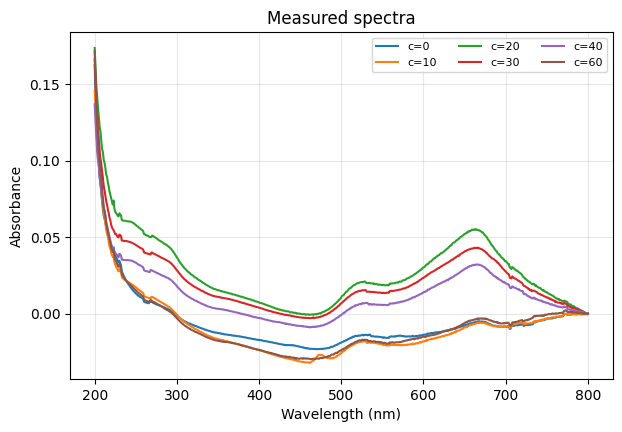

Saved: /content/drive/MyDrive/ArsenicSTS/UVVisImgs/measured_spectra.png
Saved: /mnt/data/UVVisImgs/measured_spectra.png


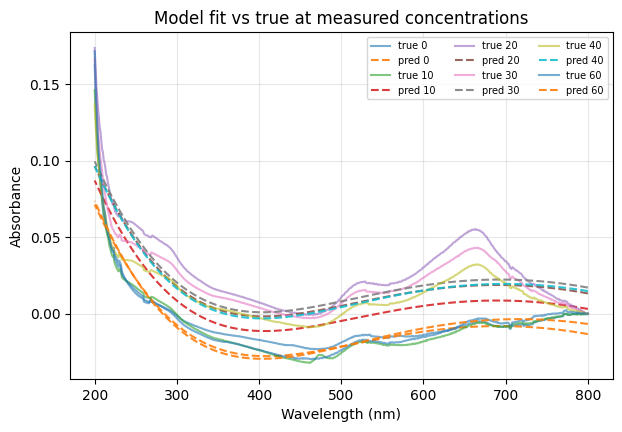

Saved: /content/drive/MyDrive/ArsenicSTS/UVVisImgs/fit_vs_true.png
Saved: /mnt/data/UVVisImgs/fit_vs_true.png


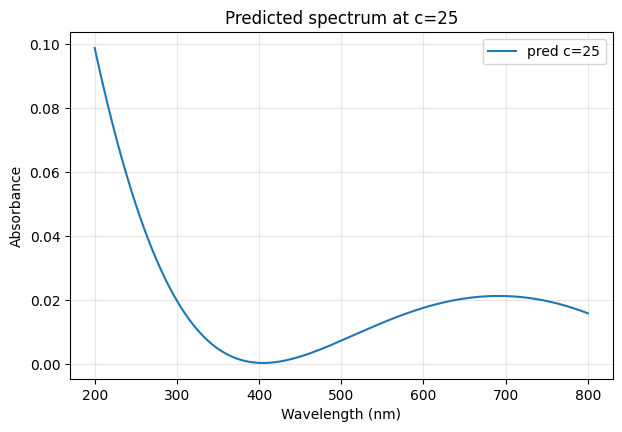

Saved: /content/drive/MyDrive/ArsenicSTS/UVVisImgs/pred_c25.png
Saved: /mnt/data/UVVisImgs/pred_c25.png
Saved: /content/drive/MyDrive/ArsenicSTS/UVVisImgs/pred_c25.csv
Saved: /mnt/data/UVVisImgs/pred_c25.csv


In [4]:
# === Minimal coordinate-MLP for UV-Vis: f([lambda, c]) -> absorbance ===
# This cell is your provided code (unaltered in logic), plus a short block at the end
# that: (1) shows plots inline and (2) saves them to Drive and /mnt/data.
#
# If in Colab, make sure you have already mounted Drive:
# from google.colab import drive
# drive.mount('/content/drive')

import os, json, random
import numpy as np
import pandas as pd
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Repro
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ROOT = "/content/drive/MyDrive/ArsenicSTS"
DATA_CSV = f"{ROOT}/UVVisData/0.30MB_AuNP_As.csv"

# ---- Load CSV and make baseline-corrected matrix A[601,6] ----
def load_uvvis(path, baseline_correct=True):
    df = pd.read_csv(path)
    df.columns = [str(c).strip() for c in df.columns]
    wl = df["Wavelength"].to_numpy().astype(np.float32)
    conc_cols = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            float(c); conc_cols.append(c)
        except:
            pass
    conc_vals = np.array(sorted([float(c) for c in conc_cols], key=float), dtype=np.float32)
    cols_sorted = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([df[c].to_numpy().astype(np.float32) for c in cols_sorted], axis=1)  # [601,6]
    if baseline_correct:
        idx_800 = int(np.argmin(np.abs(wl - 800.0)))
        A = A - A[idx_800:idx_800+1, :]
    return wl, conc_vals, A

wl, concs, A = load_uvvis(DATA_CSV, baseline_correct=True)
assert wl.shape[0] == 601 and A.shape == (601, len(concs))
C_MIN, C_MAX = float(concs.min()), float(concs.max())

# ---- Build coordinate dataset: X=[lambda_norm, c_norm], y=absorbance ----
lam_norm = (wl - wl.min()) / (wl.max() - wl.min() + 1e-12)  # [601]
c_norm   = (concs - C_MIN) / (C_MAX - C_MIN + 1e-12)        # [6]

Xs, ys = [], []
for j, cn in enumerate(c_norm):
    lam_grid = np.repeat(lam_norm[:, None], 1, axis=1)[:, 0]            # [601]
    c_grid   = np.full_like(lam_grid, fill_value=cn, dtype=np.float32)  # [601]
    Xs.append(np.stack([lam_grid, c_grid], axis=1))                      # [601,2]
    ys.append(A[:, j])                                                   # [601]
X = np.concatenate(Xs, axis=0).astype(np.float32)  # [601*6, 2]
y = np.concatenate(ys, axis=0).astype(np.float32)  # [601*6]

# Simple global scaling of y is optional. Often not needed. Keep identity:
y_mean, y_std = 0.0, 1.0
# If you see instability, uncomment:
# y_mean, y_std = float(y.mean()), float(y.std() + 1e-6)
# y = (y - y_mean) / y_std

# Small train-val split
n = X.shape[0]
idx = np.arange(n); np.random.shuffle(idx)
n_val = max(600, int(0.1 * n))
val_idx, train_idx = idx[:n_val], idx[n_val:]
Xtr, ytr = X[train_idx], y[train_idx]
Xva, yva = X[val_idx], y[val_idx]

train_loader = DataLoader(TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(ytr)),
                          batch_size=1024, shuffle=True, drop_last=False)
val_loader   = DataLoader(TensorDataset(torch.from_numpy(Xva), torch.from_numpy(yva)),
                          batch_size=2048, shuffle=False, drop_last=False)

# ---- Tiny MLP ----
class CoordMLP(nn.Module):
    def __init__(self, hidden=128, depth=3):
        super().__init__()
        layers = [nn.Linear(2, hidden), nn.SiLU()]
        for _ in range(depth-1):
            layers += [nn.Linear(hidden, hidden), nn.SiLU()]
        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model = CoordMLP(hidden=128, depth=3).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
mse = nn.MSELoss()

# Optional smoothness on lambda via finite diff on a dense lambda grid
def lambda_smooth_penalty(net, c_val_norm, lam_n=601, w=0.0):
    if w <= 0.0:
        return torch.tensor(0.0, device=DEVICE)
    lam = torch.linspace(0.0, 1.0, lam_n, device=DEVICE)[:, None]  # [L,1]
    cvec = torch.full_like(lam, fill_value=c_val_norm)             # [L,1]
    inp = torch.cat([lam, cvec], dim=1)
    A_pred = net(inp).squeeze(1)                                   # [L]
    d2 = A_pred[:-2] - 2*A_pred[1:-1] + A_pred[2:]
    return w * (d2.pow(2).mean())

# ---- Train ----
best_val = float("inf")
patience, bad = 100, 0
for epoch in range(2000):
    model.train()
    for xb, yb in train_loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        pred = model(xb).squeeze(1)
        loss = mse(pred, yb)
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
    # val
    model.eval()
    with torch.no_grad():
        vs, ncount = 0.0, 0
        for xb, yb in val_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            pred = model(xb).squeeze(1)
            vs += mse(pred, yb).item() * xb.size(0)
            ncount += xb.size(0)
        vloss = vs / ncount
    if vloss + 1e-7 < best_val:
        best_val = vloss; bad = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        bad += 1
    if (epoch+1) % 100 == 0:
        print(f"epoch {epoch+1}  train {float(loss):.4e}  val {vloss:.4e}")
    if bad >= patience:
        print(f"Early stop at {epoch+1}, best val {best_val:.4e}")
        break

# Restore best
model.load_state_dict(best_state)

# ---- Helper: predict full spectrum at any c* ----
def predict_spectrum(model, wl_nm, c_star):
    lam_n = (wl_nm - wl_nm.min()) / (wl_nm.max() - wl_nm.min() + 1e-12)
    c_n = np.full_like(lam_n, fill_value=(c_star - C_MIN) / (C_MAX - C_MIN + 1e-12), dtype=np.float32)
    Xq = torch.from_numpy(np.stack([lam_n.astype(np.float32), c_n], axis=1)).to(DEVICE)
    with torch.no_grad():
        yq = model(Xq).squeeze(1).cpu().numpy()
    # invert scaling if you enabled it above
    yq = yq * y_std + y_mean
    return yq

# ---- Quick sanity: RMSE on the six training concentrations ----
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))

for cj in concs:
    y_hat = predict_spectrum(model, wl, float(cj))
    err = rmse(A[:, list(concs).index(cj)], y_hat)
    print(f"RMSE at c={int(cj)}: {err:.5f}")

# Example prediction at an intermediate concentration
c_star = 25.0
A_hat = predict_spectrum(model, wl, c_star)
print("Predicted spectrum at c=25 has shape:", A_hat.shape)

# ===================================================================
# Extra block: plot inline and save to Drive and /mnt/data
# ===================================================================
import matplotlib.pyplot as plt

drive_dir = os.path.join(ROOT, "UVVisImgs")
local_dir = "/mnt/data/UVVisImgs"
os.makedirs(drive_dir, exist_ok=True)
os.makedirs(local_dir, exist_ok=True)

def save_both(fig, name):
    drive_path = os.path.join(drive_dir, name)
    local_path = os.path.join(local_dir, name)
    fig.savefig(drive_path, dpi=160, bbox_inches="tight")
    fig.savefig(local_path, dpi=160, bbox_inches="tight")
    print(f"Saved: {drive_path}")
    print(f"Saved: {local_path}")

# Plot all measured spectra
fig1 = plt.figure(figsize=(7,4.5))
for j, c in enumerate(concs):
    plt.plot(wl, A[:, j], label=f"c={int(c)}")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Measured spectra")
plt.legend(ncol=3, fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()
save_both(fig1, "measured_spectra.png")

# Plot model fit vs true at measured concentrations
fig2 = plt.figure(figsize=(7,4.5))
for j, c in enumerate(concs):
    A_pred_j = predict_spectrum(model, wl, float(c))
    plt.plot(wl, A[:, j], label=f"true {int(c)}", alpha=0.6)
    plt.plot(wl, A_pred_j, label=f"pred {int(c)}", linestyle="--", alpha=0.9)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Model fit vs true at measured concentrations")
plt.legend(ncol=3, fontsize=7)
plt.grid(True, alpha=0.3)
plt.show()
save_both(fig2, "fit_vs_true.png")

# Plot prediction for c=25
fig3 = plt.figure(figsize=(7,4.5))
plt.plot(wl, A_hat, label="pred c=25")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Predicted spectrum at c=25")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
save_both(fig3, "pred_c25.png")

# Save c=25 as CSV
pred_csv_drive = os.path.join(drive_dir, "pred_c25.csv")
pred_csv_local = os.path.join(local_dir, "pred_c25.csv")
np.savetxt(pred_csv_drive, np.column_stack([wl, A_hat]), delimiter=",", header="Wavelength,Absorbance", comments="")
np.savetxt(pred_csv_local, np.column_stack([wl, A_hat]), delimiter=",", header="Wavelength,Absorbance", comments="")
print(f"Saved: {pred_csv_drive}")
print(f"Saved: {pred_csv_local}")